In [0]:
import pandas as pd #Loading pandas library, it is used for reading csv file and modifying it
import numpy as np

In [158]:
df = pd.read_csv('1429_1.csv') #Reading the dataset. It contains many columnsas shown below

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


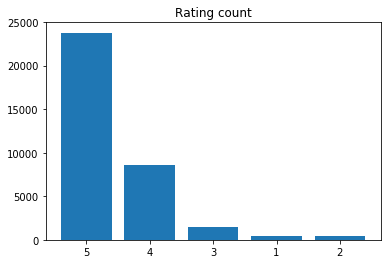

In [160]:
import matplotlib.pyplot as plt
objects = (5,4,3,1,2)
y_pos = np.arange(len(objects))
plt.bar(y_pos, df['reviews.rating'].value_counts(), align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.title('Rating count')
plt.show()

In [0]:
df = df[['name','categories','reviews.rating','reviews.text','reviews.title']]
#We will only use name, categories, review rating, text and title for making the prediction

df = df.loc[~df['reviews.rating'].isnull()] #Removing rows where rating is null

In [0]:
y = df['reviews.rating'] #Storing the rating in different variable 
df = df.drop('reviews.rating',axis=1) #Removing rating from our original dataframe.

In [163]:
df.head() #This is our new table, which we will use for training

,name,categories,reviews.text,reviews.title
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",This product so far has not disappointed. My c...,Kindle
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",great for beginner or experienced person. Boug...,very fast
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",I bought this for my grand daughter when she c...,Fantastic Tablet for kids


In [0]:


#Machines cannot understand text, only numbers. So we will convert each and every word to a speicfic number in such  way
# that it makes sense.
#For example, the word "Queen" and "King" are related. So the number for both the numbers must be similar.
#But not exactly the same...


#So we will use NLTK library, it will automatically find and assign a good numberto each word


In [0]:
from scipy.sparse import csr_matrix,hstack # NLTK converts the table in CSR Matrix format. So we are importing it
from sklearn.feature_extraction.text import TfidfVectorizer #This will convert our words to numbers

Vectorize = TfidfVectorizer() #Just defining it. 
nameNLP = Vectorize.fit_transform(df["name"].astype('str')) #Applying word eembedding function to name column
#and storing the result in nameNLP variable.
reviewTextNLP = Vectorize.fit_transform(df["reviews.text"].astype('str'))
#Applying word embedding to text column and storing the result in reviewTextNLP variable
#Converting text to number is called word embeddings


#Applying NLP to title column and storing the result in reviewTitleNLP
reviewTitleNLP = Vectorize.fit_transform(df["reviews.title"].astype('str'))

#Now we don't need these 3 columns, we got the numbers of these. So we are removingthem
#from our original table
df = df.drop(['name','reviews.text','reviews.title'],axis=1)

In [165]:
df.head() #Now we have just one column left in our table, which is category.
#It contains multiple categories seperated by ","

,categories
0,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."
1,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."
2,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."
3,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."
4,"Electronics,iPad & Tablets,All Tablets,Fire Ta..."


In [0]:
df = df.categories.str.split(",",expand=True) #So we make a new variable, which splits the column by ","

In [167]:
df.head() #This is our new table. It made new column for each and every category. But the results are in text, so we convert them to number using below function

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [0]:
df = pd.get_dummies(df) #It will assign a unique number to each and every category

In [0]:
df = hstack((csr_matrix(df),nameNLP,reviewTextNLP,reviewTitleNLP )) #Now 


#The nameNLP, reviewTextNLP, reviewTitleNLP are in CSR matrix format. So we convert our table "df" into CSV matrix format, and merge all these variables into one 

In [170]:
df.shape #Now our new matrix has 34627 rows and 18249 columns...One for each word

(34627, 18249)

In [0]:
y = y.astype('category').cat.codes #We convert the rating into category format. Since we want to predict 1,2,3,4,5....Not 4.3455, 3.5334..not numerical, i mean

In [0]:
from sklearn.model_selection import train_test_split #We will use this for splitting the data into test and train

In [0]:
train, test, y, y_test = train_test_split(df, y, test_size=0.2, random_state=42) #We split the Data into 80% train and 20% test

In [0]:
import lightgbm #WE will use Lightgbm for training purpose. 

In [175]:
#Give Train & Target variable to LightGBM, and it will transform them to a format it accepts
train_set = lightgbm.Dataset(train, label=y)
#Give Validation train & validaion Target variable to LightGBM, and it will transform them to a format it accepts
test_set = lightgbm.Dataset(test, label=y_test)

#Set LightGBM Parameters...Just some technical parameters here
params = {'objective':'multiclass', #The objective is multiclass...it is usedwhen we have more than two cateogries. we have 5,...rating scan be 1,2,3,4,5
         'num_leaves' : 30,
          'num_class':5, #Define total number of classes...which is 5.....1,2,3,4,5
         'learning_rate': 0.05, #Define the leanring rate
         "metric": 'multi_error', #Define the evaluation metric
         "verbosity": -1}
evals_result = {}
model = lightgbm.train(params #Call the train funciton
                      , train_set
                      , num_boost_round = 500
                      , valid_sets = [train_set,test_set]
                      , verbose_eval = 100
                      , early_stopping_rounds = 50
                       ,evals_result=evals_result
                       #It will check every 50th round of training, if the accuracy is still increasing. If it stops increasing
                       #we stop the training. #Now this should take 3-5 minutes to run.
                     )

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_error: 0.217104	valid_1's multi_error: 0.267109
[200]	training's multi_error: 0.183387	valid_1's multi_error: 0.264222
Early stopping, best iteration is:
[222]	training's multi_error: 0.178333	valid_1's multi_error: 0.262778


Plotting metrics recorded during training...


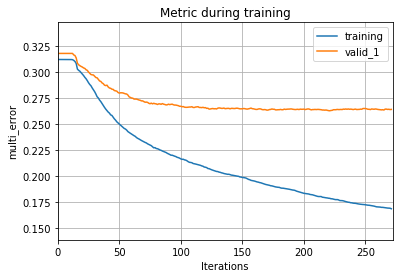

In [176]:
print('Plotting metrics recorded during training...')
ax = lightgbm.plot_metric(evals_result, metric='multi_error')
plt.show()

In [0]:
from sklearn.metrics import accuracy_score #We import the evaluation metric here

In [178]:
y_pred = model.predict(test) #We predict on the test dataset, using the predict function & the "model", which we just trained
y_pred #It predicts the probablity of each rating. So in the first row, the 4th value has highest probablity.

array([[1.24795627e-02, 7.11240362e-03, 6.72584917e-02, 2.09697269e-01,
        7.03452273e-01],
       [1.43833999e-03, 1.61977430e-02, 5.18530213e-02, 6.91605058e-01,
        2.38905838e-01],
       [1.42380317e-04, 3.63721992e-04, 2.10712158e-02, 4.51954309e-01,
        5.26468373e-01],
       ...,
       [1.21748086e-03, 3.87506266e-03, 3.51410623e-02, 4.54316492e-01,
        5.05449902e-01],
       [2.25761163e-04, 9.10790440e-04, 6.70121621e-02, 8.10255540e-01,
        1.21595747e-01],
       [4.98644351e-04, 8.62462498e-04, 8.81741749e-03, 2.24287468e-01,
        7.65534007e-01]])

In [179]:
#So we get the index of highest value in each row

y_pred = np.argmax(y_pred,axis=1)
y_pred #We finally got the rating that the model predicted, now we can find out the accuracy.

array([4, 3, 4, ..., 4, 3, 4])

In [180]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)*100)+"%") #Print the accuracy, and that's it.

Accuracy: 73.72220617961305%


In [181]:
df = pd.read_csv('1429_1.csv') 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df[['name','categories','reviews.text','reviews.title','reviews.rating']]
#We will only use name, categories, review rating, text and title for making the prediction

df = df.loc[~df['reviews.rating'].isnull()] #Removing rows where rating is null
y=df['reviews.rating']

In [0]:
train, test, y, y_test = train_test_split(df, y, test_size=0.2, random_state=42) #We split the Data into 80% train and 20% test

In [184]:
test['prediction'] = y_pred+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [185]:
test

,name,categories,reviews.text,reviews.title,reviews.rating,prediction
34642,NaN,"Power Adapters & Cables,Electronics,USB Cables",I bought this for myself because i play my kin...,power cord for kindle fire,5.0,5
8315,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Fire Tablets,Tablets,Computers & Tablets,All T...","My daughter is away at school, and she uses th...",Works well,5.0,4
11286,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Fire Tablets,Tablets,Computers & Tablets,All T...",Bought this tablet for kids. Great price for w...,great price for tablet,5.0,5
30128,NaN,"Back To College,College Electronics,College Tv...",Great little device to save money. Streams liv...,Amazon Fire TV,4.0,5
28520,NaN,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",I have wanted Echo ever since it came out. I o...,Alexia is home.,5.0,5
3470,"All-New Kindle E-reader - Black, 6 Glare-Free ...","Amazon Devices & Accessories,Amazon Device Acc...",like the firs one that folds in prongs better,Five Stars,5.0,5
21960,"Echo (White),,,\r\nEcho (White),,,","Stereos,Remote Controls,Amazon Echo,Audio Dock...",I love asking Alexa questions and getting the ...,"Great source of music, news and weather",5.0,5
10529,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Fire Tablets,Tablets,Computers & Tablets,All T...",The graphic display is vibrant and just the ri...,Best Reader Small Tablet for Price,5.0,5
25053,Amazon - Amazon Tap Portable Bluetooth and Wi-...,"Stereos,Remote Controls,Amazon Echo,Audio Dock...","Echo is a great , it can answer all questions ...",Great value,5.0,5
8439,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Fire Tablets,Tablets,Computers & Tablets,All T...",I have one that I love so that I purchased thi...,This is a great product!,5.0,5
